## Machine-Learning Atomic Charges for Efficient Molecular Dynamics Simulations

### Motivation
Partitioning the electron density of a molecule (or collection of molecules)
is of fundamental importance in simulating molecular motion using molecular
dynamics. Traditionally, partitioning the electron density requires a 
relatively expensive wavefunction or density functional theory (DFT) calculation,
methods that formally scale as at least $\mathcal{O}(N^3)$. By contrast, the underlying
molecular dynamics scales approximately as $\mathcal{O}(N)$, making the DFT the
rate-limiting step.


Here, we construct an empirical model of atomic charge partitioning with
asymptotic $\mathcal{O}(N^2)$ cost, reducing the formal scaling of the entire method
by $\mathcal{O}(N)$.


To accomplish this, we map an atom in its environment to a corresponding
scalar, its atomic charge. The atomic charge label is computed by the minimal
basis iterative stockholder (MBIS) algorithm performed on a second-order
perturbative wavefunction from the simplest truncation of symmetry-adapted
perturbation theory (SAPT0).

i.e. We seek the function that maps the atomic environment ($\vec{X}$) to its
corresponding atomic charge ($y$):

$\vec{X} \leftarrow y$

Here, choosing $\vec{X}$ (Coulomb matrices, symmetry functions, graph convolutions),
and an appropriate functional form (KRR, k-NN, MLP) are critical in achieving
a sufficiently fast and physically meaningful mapping.

In [1]:
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPRegressor

Here are simple imports for what we'll need. For more complex model architectures, Google's neural network library TensorFlow may be useful. We find excellent results with the simple MLP implementation in scikit-learn.


### Featurization

Now, we'll define a couple options for $\vec{X}$, our "atomic environment vectors" -- the (local) Coulomb matrix and symmetry functions:

The Coulomb matrix is defined as
$$C_{ij} =
      \left\{ \begin{array}{ll}
          \frac{Z_i Z_j}{r_{ij}}& i \neq j \\
          Z_i^2 & i = j
      \end{array} \right.$$
The local version of the Coulomb matrix, used for efficiency and constant vector sizes, only considers the nearest $n$ $j$ in Euclidian distance. The matrix is flattened and fed as input to any statistical algorithm.

The radial symmetry function is defined as 
$$G_{i}^{rad}(\mu, \eta, Z) = \sum_{j \ne i}e^{-\eta(r_{ij}-\mu)^2}f_{c}(r_{ij})\delta_{ZZ_{j}},$$ with cutoff function $f_c(r_{ij})$ to enforce locality, $$f_{c}(r_{ij})=
      \left\{ \begin{array}{ll}
          \frac{1}{2}(\cos(\frac{r_{ij}}{r_c}) + 1) & r_{ij}\leq r_c \\
          0 & r_{ij} > r_c
      \end{array} \right. ,$$
and $\delta_{ZZ_{j}}$ is the Kronecker delta, enforcing different "channels" for different nearby nuclei.


Both of these have options, which can be seen as hyperparameters. For the local Coulomb matrix, $n$ decides how many atomic neighbors are considered. The symmetry functions, which are simply a set of radial Gaussian shells, have an $\eta$ parameter, determining the width of each Gaussian, $\mu$, determining the offset of each gaussian from the origin atom, and $r_c$, the cutoff distance. In practice, $r_c$ rarely exceeds $5$ angstroms, $\mu$ is evenly spaced between a small number ($0.5$ angstroms, or so) and $r_c$, and $\eta$ is treated as a true hyperparameter.

In [2]:
def get_local_coulomb(R, Z, n=5):
    """
    Generates local Coulomb matrix for set of molecules
    Args: Unpadded list of cartesian coords, atom nums
        optional: number of neighbors to consider default=5
    Returns: Unrolled list of local atomic coulomb matrices
    """
    C = []
    dists = []
    for i, coords in enumerate(R):
        dists = distance_matrix(coords, coords)
        for j in range(dists.shape[0]):
            inds = dists[j].argsort()[:n]
            R_local = np.zeros((n,n))
            ZZ_local = np.zeros((n,n))
            for k in range(len(inds)):
                for l in range(len(inds)):
                    if k != l:
                        R_local[k][l] = dists[inds[k],inds[l]]
                    elif k == l:
                        R_local[k][l] = 1.0 #fixes diagonal inf
                    ZZ_local[k][l] = Z[i][inds[k]] * Z[i][inds[l]]
            C.append(ZZ_local / R_local)
    C = np.array(C)
    return np.reshape(C, (C.shape[0], C.shape[1]**2))

def get_symmetry_functions(R, Z, eta=2., num = 20, r_c = 5.):
    """
    Generates weighted radial symmetry functions for each atom in a set of
    molecules a la Behler, Parrinello, Gastegger, Marquetand.
    Args: Unpadded list of Cartesian coords, atom nums
        optional:
         eta      : hyperparameter, corresponding to Gaussian widths
         num : hyperparameter, corresponding to number of Gaussians
         r_c      : hyperparameter, corresponding to cutoff radius
    Returns: Unrolled list of atomic radial symmetry functions
    """
    Z_dict = {1.0 : 0,
              6.0 : 1,
              7.0 : 2,
              8.0 : 3,
              9.0 : 4,
              16.0: 5,}

    G = []
    mu = np.linspace(0.8, r_c, num)
    for i, coords in enumerate(R):
        dists = distance_matrix(coords, coords)
        for j in range(dists.shape[0]):
            atom_G = np.zeros(len(mu)*len(Z_dict))
            for k in range(dists.shape[0]):
                if j != k:
                    if dists[j][k] < r_c:
                        cutoff = 0.5 * (np.cos(dists[j][k] / r_c) + 1)
                    else: cutoff = 0.0
                    exp_term = np.exp(-eta * dists[j][k] - mu) ** 2
                    ind = Z_dict[Z[i][k]] * len(mu)
                    atom_G[ind:ind+len(mu)] += exp_term * cutoff
            G.append(atom_G)
    return np.array(G)

These implementations return a flattened set of vectors, each vector describing an atom's environment. Therefore, the shape of the Coulomb matrix function's return is (number_of_atoms, n^2). The shape of the symmetry function return is (number_of_atoms, number_of_elements * num), where num is the hyperparameter controlling the number of radial Gaussians.

### Loading in data

In [3]:
def reconstitute(RAp, RBp, ZAp, ZBp, QAp, QBp):
    """
    Args: padded individual monomer coordinates, atom nums, and charges
    Returns: unpadded, concatenated coords, atom nums, and charges
    """
    R = []
    Z = []
    Q = []
    for i in range(len(RAp)):
        R_mol = []
        Z_mol = []
        Q_mol = []
        for j in range(len(RAp[i])):
            if ZAp[i][j] != 0:
                R_mol.append(RAp[i][j])
                Z_mol.append(ZAp[i][j])
                Q_mol.append(QAp[i][j])
        for j in range(len(RBp[i])):
            if ZBp[i][j] != 0:
                R_mol.append(RBp[i][j])
                Z_mol.append(ZBp[i][j])
                Q_mol.append(QBp[i][j])
        R.append(np.array(R_mol))
        Z.append(np.array(Z_mol))
        Q.append(np.array(Q_mol))
    return R, Z, Q

# load in system names, electrons, atomic numbers, and coordinates
names = np.load("bms_data/names_train.npy")
e_A = np.load("bms_data/Q_A_train.npy")
e_B = np.load("bms_data/Q_B_train.npy")
Z_A = np.load("bms_data/Z_A_train.npy")
Z_B = np.load("bms_data/Z_B_train.npy")
R_A = np.load("bms_data/R_A_train.npy")
R_B = np.load("bms_data/R_B_train.npy")
    
Q_A = Z_A - e_A
Q_B = Z_B - e_B
    
# these are split by monomer and padded, reconstituting total system w/o pad
R, Z, Q = reconstitute(R_A, R_B, Z_A, Z_B, Q_A, Q_B)

These data are molecular dimers whose chemistry is relevant in drug discovery. Specifically, the training configurations have been artificially sampled based on the intuition of a team of medicinal chemists, not drawn from any experimental study. Being loaded and parsed are
1. R : Cartesian coordinates of each atom in each system
2. Z : Atomic numbers of each atom in each system
3. Q : Atomic charges (y), which we seek to predict

Also included in the bms_data directory are "*_val.npy" files, which will be used as a final validation set. These are sensible choices of validation data because these molecular dimers are drawn from experimental crystallographic data, so are by construction physically reasonable configurations that medicinal chemists might be interested in.

Good performance on the crystallographic validation set would indicate that the training and testing sets, both drawn from artificial configurations, are sufficient to model the underlying physics of electron distributions.

### Generating features and training models

Below is code that generates local Coulomb matrices and radial symmetry functions, given the input R and Z:

In [4]:
## generate atomic environment descriptors

#X = get_local_coulomb(R, Z, n=5)
X = get_symmetry_functions(R, Z, eta=1., num=15)

##The following feature represents the null hypothesis, where atoms
## are defined only by their atomic number. As you would expect,
## this doesn't work very well.
#C = np.expand_dims(np.hstack(Z), -1)
##

y = np.hstack(Q)

X_mlp = X[::5]
y_mlp = y[::5]
mlp = MLPRegressor(hidden_layer_sizes=(20,20), early_stopping=True, n_iter_no_change=10)
scoring = ('r2', 'neg_mean_absolute_error')
cv_results = cross_validate(mlp, X_mlp, y_mlp, cv=3, scoring=scoring, return_train_score=True)
    
print(cv_results)

/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


{'fit_time': array([26.4629271 , 33.5600152 , 33.32647753]), 'score_time': array([0.11464763, 0.13815117, 0.13547611]), 'test_r2': array([0.84527799, 0.7441414 , 0.82645928]), 'train_r2': array([0.84351576, 0.74978114, 0.82330603]), 'test_neg_mean_absolute_error': array([-0.09158523, -0.13871811, -0.09986697]), 'train_neg_mean_absolute_error': array([-0.09133306, -0.13780175, -0.10133563])}


This preliminary effort makes available many optimizations for improving fast charge predictions:

1. Exploring descriptor hyperparameters


    a. Local Coulomb matrices depend on n, a natural number referring to the number of atomic neighbors to consider.   
    b. Symmetry functions depend on $\eta$, num, and $r_c$, determining Gaussian widths, number of Gaussians, and cutoff radius, respectively.
    
    
2. Exploring model types


    a. KRR is accurate with little data but is potentially expensive with the quantity of data we have
    b. Neural networks are fast at inference-time but have many hyperparameters and can be cumbersome to train
    c. k-NN is potentially accurate but has high memory cost and non-smooth inferences w.r.t. molecular motion
    
    
3. Exploring model hyperparameters -- each of the above have several hyperparameters that will affect performance

### Principal Component Analysis (PCA)

Reducing the dimensions of the $\vec{X}$ matrix will improve speed and memory footprint as there are likely redundant features.

Original X: (225921, 90)
Reduced X: (225921, 6)
Retained variance: (0.9999999999999999+0j)
Rank of covariance matrix: 6


/home/derek/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


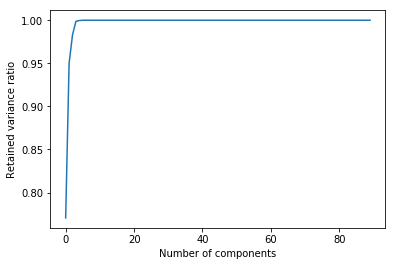

In [5]:
X = get_symmetry_functions(R, Z, eta=1., num=15)

C = np.cov(X.T)
eig_vals, eig_vecs = np.linalg.eig(C)
eig_vecs = eig_vecs.T 
sorted_idxs = np.argsort(eig_vals) 
sorted_idxs = list(sorted_idxs)
sorted_idxs.reverse() 
eig_vals = eig_vals[sorted_idxs] 
eig_vecs = eig_vecs[sorted_idxs, :]


## Only keep the highest k eigenvalues/eigenvectors
k = 6
projector = eig_vecs[:k, :].T
print('Original X: {}'.format(X.shape))
X_k = np.dot(X,projector)
print('Reduced X: {}'.format(X_k.shape))
print('Retained variance: {}'.format(sum(eig_vals[:k])/sum(eig_vals)))

## Scree plot
fig, ax = plt.subplots()
N = len(eig_vals)
ax.plot(range(N), np.cumsum(eig_vals)/sum(eig_vals))
ax.set_xlabel('Number of components')
ax.set_ylabel('Retained variance ratio')

print('Rank of covariance matrix: {}'.format(np.linalg.matrix_rank(C)))

## Model & Hyperparameter Optimization

### Kernel Ridge Regression

Below is code that generates radial symmetry functions and performs KRR using RBF kernel.

In [6]:
## KRR
from sklearn.kernel_ridge import KernelRidge

X = get_symmetry_functions(R, Z, eta=1., num=5)
y = np.hstack(Q)

X_krr = X[::40]
y_krr = y[::40]


## Using a train test split
from sklearn.model_selection import train_test_split
np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(X_krr, y_krr, test_size=0.4)


## GridSearchCV to tune KRR parameters alpha and gamma

from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25])
gammas = 1./(2*sigmas**2)

alphas = np.array([1e-9, 1e-8, 1e-7])

parameter_ranges = {'alpha':alphas, 'gamma':gammas}

KRR = KernelRidge(kernel='rbf')
KRR.fit(X_train,y_train)
KRR_search = GridSearchCV(KRR, parameter_ranges, cv=3)
KRR_search.fit(X_train,y_train)
print(KRR_search.best_estimator_, KRR_search.best_score_)

KernelRidge(alpha=1e-09, coef0=1, degree=3, gamma=0.02, kernel='rbf',
      kernel_params=None) 0.6219538306040542


Because of the expense of kernel ridge regression, fewer features must be formed and only small subsets of the total data may be used. Naturally, this yields worse performance.

What if instead we use the PCA dimensionality-reduced data, in which we can use many symmetry functions and 4x as many data points?

In [8]:
X = get_symmetry_functions(R, Z, eta=1., num=15)
y = np.hstack(Q)

## Using a train test split
np.random.seed(0)
X_krr = X[::10]
y_krr = y[::10]

X_k = np.dot(X_krr, np.real(projector))
X_train, X_test, y_train, y_test = train_test_split(X_k, y_krr, test_size=0.3)

## GridSearchCV to tune KRR parameters alpha and gamma

from sklearn.model_selection import GridSearchCV

sigmas = np.array([5, 10, 15, 20, 25])
gammas = 1./(2*sigmas**2)

alphas = np.array([1e-9, 1e-8, 1e-7])

parameter_ranges = {'alpha':alphas, 'gamma':gammas}

KRR = KernelRidge(kernel='rbf')
KRR.fit(X_train,y_train)
KRR_search = GridSearchCV(KRR, parameter_ranges, cv=3)
KRR_search.fit(X_train,y_train)
print(KRR_search.best_estimator_, KRR_search.best_score_)

KernelRidge(alpha=1e-09, coef0=1, degree=3, gamma=0.02, kernel='rbf',
      kernel_params=None) 0.6654976031097078


In [9]:
## Using GridSearchCV hyperparameters
KRR_tuned = KernelRidge(alpha = 1e-09, kernel='rbf', gamma = 0.02)
KRR_tuned.fit(X_train,y_train)
r2_train = KRR_tuned.score(X_train,y_train)
print('Train score: {}'.format(r2_train))

r2_test = KRR_tuned.score(X_test,y_test)
print('Test score: {}'.format(r2_test))

Train score: 0.6722792956151545
Test score: 0.6560929570669378


### K-nearest neighbors regression

In [10]:
# Import additional packages
from sklearn.metrics import confusion_matrix
from scipy.optimize import minimize
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils import shuffle

In [11]:
X = get_symmetry_functions(R, Z, eta=1., num=15)
y = np.hstack(Q)

In [12]:
# Split the data into test and train if you like
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train, y_train = shuffle(X_train, y_train)

In [13]:
# Optimize hyperparameters for KNN Regressor
neighbors = [1, 2, 3, 5, 10, 50]
parameter_ranges = {'n_neighbors':neighbors}
knn = KNeighborsRegressor() # n_neighbors=?
knn_search = GridSearchCV(knn, parameter_ranges, cv=3)
knn_search.fit(X_train,y_train)
y_knn = knn_search.best_estimator_.predict(X_test)
print(knn_search.best_estimator_)
print('')
print(f'best score = {knn_search.best_score_}')
print(f'n_neighbors = {knn_search.best_estimator_.n_neighbors}')

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=10, p=2,
          weights='uniform')

best score = 0.9857835567418594
n_neighbors = 10


k-NN benefits greatly from being able to use all of the data in a reasonable amount of time.

### Multilayer Perceptron
We showed an MLP in our training example, but didn't use all the data or bother to optimize its hyperparameters. Let's do that, with our dimensionality-reduced features for efficiency.

In [19]:
X = get_symmetry_functions(R, Z, eta=1., num=15)
X_k = np.dot(X, np.real(projector))
X_k = X_k[::2]

y = np.hstack(Q)
y_k = y[::2]
layers = [(10,10), (25,25), (50,25)]
# FYI, independent experiments with other hyperparams
# showed some sklearn defaults are, in fact, best. This
# notebook simply shows an illustrative example.
mlp = MLPRegressor(early_stopping=True, n_iter_no_change=10)

parameter_ranges = {'hidden_layer_sizes':layers}
mlp_search = GridSearchCV(mlp, parameter_ranges, cv=3)
mlp_search.fit(X_k, y_k)
scoring = ('r2', 'neg_mean_absolute_error')

print(mlp_search.best_estimator_, mlp_search.best_score_)

/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/derek/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 25), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 0.9023548725941979


# Model Validation

### Two models show excellent performance and are able to handle the amount of data available:
###                                   MLP and k-NN
MLP may be useful when output charges need to be continuous with respect to changing molecular geometries, like in the case of molecular dynamics. k-NN appears to be more accurate, but is discontinuous with respect to changing geometries. This could be used for single-point electrostatic energy calculations.

#### How does each model validate on our out-of-sample crystallographic data?

Loading in the special holdout data:

In [20]:
# load in system names, electrons, atomic numbers, and coordinates
names = np.load("bms_data/names_val.npy")
e_A = np.load("bms_data/Q_A_val.npy")
e_B = np.load("bms_data/Q_B_val.npy")
Z_A = np.load("bms_data/Z_A_val.npy")
Z_B = np.load("bms_data/Z_B_val.npy")
R_A = np.load("bms_data/R_A_val.npy")
R_B = np.load("bms_data/R_B_val.npy")
    
Q_A = Z_A - e_A
Q_B = Z_B - e_B
    
# these are split by monomer and padded, reconstituting total system w/o pad
R, Z, Q = reconstitute(R_A, R_B, Z_A, Z_B, Q_A, Q_B)

In [21]:
X = get_symmetry_functions(R, Z, eta=1., num=15)
X_val = X.copy()
y = np.hstack(Q)
y_val = y.copy()

Now for validating our models.
First, the best k-nearest neighbors model:

In [22]:
# Calculate the coefficient of determination R^2 for all the following predictions
knn_y_prd = knn_search.predict(X_val)
knn_r2_val = knn_search.score(X_val, y_val)
print(f'k-NN Validation R2  \t{round(knn_r2_val,3)}')

k-NN Validation R2  	0.925


Next, the best MLP model:

In [24]:
X_mlp_val = np.dot(X_val, np.real(projector))
mlp_y_prd = mlp_search.predict(X_mlp_val)
mlp_r2_val = mlp_search.score(X_mlp_val, y_val)
print(mlp_search.best_estimator_, mlp_search.best_score_)
print(f'MLP Validation R2  \t{round(mlp_r2_val,3)}')

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(50, 25), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False) 0.9023548725941979
MLP Validation R2  	0.88


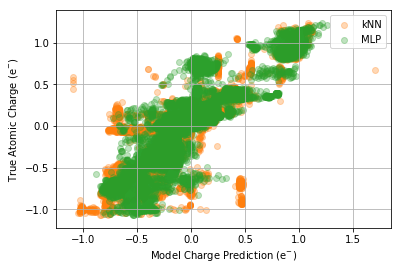

In [27]:
fig, ax = plt.subplots()

ax.scatter(knn_y_prd, y_val, c='tab:orange', label='kNN', alpha=0.3)
ax.scatter(mlp_y_prd, y_val, c='tab:green', label='MLP', alpha=0.3)

ax.legend()
ax.grid(True)
ax.set_xlabel("Model Charge Prediction (e$^{-}$)")
ax.set_ylabel("True Atomic Charge (e$^{-}$)")
plt.show()


### Quick Conclusions:
Both models seem very good for typical systems. The neural network, while slightly worse-performing in R2 and MAE, has lower maximum errors, as evidenced by the outliers visible in the plot above.

As mentioned before, the MLP has a derivative everywhere (after derivative assumptions are made over the piecewise-linear ReLU activation), so the model output varies smoothly and can be reliably used in molecular dynamics simulations.

The kNN model is generally discontinuous and non-differentiable with respect to atomic motion, so while accurate, should only be used for point-estimates.